In [ ]:
import os
import gzip
import struct
import array
import numpy as np
from urllib.request import urlretrieve

import torch
from torch.utils.data import Dataset


BASE_URL = 'http://yann.lecun.com/exdb/mnist/'


# Helper functions and imports
def download(url, filename):
    if not os.path.exists('./data'):
        os.makedirs('./data')
    out_file = os.path.join('./data', filename)
    if not os.path.isfile(out_file):
        urlretrieve(url, out_file)


def mnist():
    def parse_labels(filename):
        with gzip.open(filename, 'rb') as fh:
            magic, num_data = struct.unpack(">II", fh.read(8))
            return np.array(array.array("B", fh.read()), dtype=np.uint8)

    def parse_images(filename):
        with gzip.open(filename, 'rb') as fh:
            magic, num_data, rows, cols = struct.unpack(">IIII", fh.read(16))
            return np.array(array.array("B", fh.read()), dtype=np.uint8).reshape(num_data, rows, cols)

    for filename in ['train-images-idx3-ubyte.gz',
                     'train-labels-idx1-ubyte.gz',
                     't10k-images-idx3-ubyte.gz',
                     't10k-labels-idx1-ubyte.gz']:
        download(BASE_URL + filename, filename)

    train_images = parse_images('./data/train-images-idx3-ubyte.gz')
    train_labels = parse_labels('./data/train-labels-idx1-ubyte.gz')
    test_images  = parse_images('./data/t10k-images-idx3-ubyte.gz')
    test_labels  = parse_labels('./data/t10k-labels-idx1-ubyte.gz')
    return train_images, train_labels, test_images, test_labels


# Load and Prepare Data: Load the MNIST dataset, binarize the images, split into a training dataset
# of 10000 images and a test set of 10000 images.
def load_mnist():
    partial_flatten = lambda x : np.reshape(x, (x.shape[0], np.prod(x.shape[1:])))
    one_hot = lambda x, k: np.array(x[:,None] == np.arange(k)[None, :], dtype=int)
    train_images, train_labels, test_images, test_labels = mnist()
    train_images = partial_flatten(train_images) / 255.0
    test_images  = partial_flatten(test_images)  / 255.0
    train_labels = one_hot(train_labels, 10)
    test_labels = one_hot(test_labels, 10)
    N_data = train_images.shape[0]
    train_images = torch.from_numpy(np.round(train_images[0:10000])).float()
    train_labels = torch.from_numpy(train_labels[0:10000]).float()
    test_images = torch.from_numpy(np.round(test_images[0:10000])).float()
    test_labels = torch.from_numpy(test_labels[0:10000])
    return N_data, train_images, train_labels, test_images, test_labels


# Partition the training set into minibatches
def batch_indices(iter, num_batches, batch_size):
    # iter: iteration index
    # num_batches: number of batches
    # batch_size: batch size
    idx = iter % num_batches
    return slice(idx * batch_size, (idx+1) * batch_size)


# write a function to reshape 784 array into a 28x28 image for plotting
def array_to_image(array):
    return np.reshape(np.array(array), [28, 28])


# concatenate the images for plotting
def concat_images(images, row, col, padding = 3):
    result = np.zeros((28*row+(row-1)*padding,28*col+(col-1)*padding))
    for i in range(row):
        for j in range(col):
            result[i*28+(i*padding):i*28+(i*padding)+28, j*28+(j*padding):j*28+(j*padding)+28] = images[i+j*row]
    return result


class GANDataset(Dataset):
    def __init__(self, data_f, dev, transform=None):
        self.transform = transform
        self._load_data(data_f, dev)

    def _load_data(self, data_f, dev):
        with gzip.open(data_f, 'rb') as fid:
            head = fid.read(16)
            data = fid.read()

        res = struct.unpack(">iiii", head)
        data1 = struct.iter_unpack(">" + "B" * 784, data)

        self.d = torch.zeros(res[1], 1, res[2], res[3])
        for idx, k in enumerate(data1):
            tmp = torch.Tensor(k)
            tmp = tmp.view(1, res[2], res[3])
            if self.transform:
                tmp = self.transform(tmp)
            self.d[idx, :, :, :] = tmp

        self.d = self.d.to(dev)

    def __len__(self):
        return self.d.size()[0]

    def __getitem__(self, idx):
        return self.d[idx, :, :]

Processing dataset ...
... done. Total 60000 data entries.


  1%|          | 1/100 [01:20<2:12:50, 80.51s/it]

E: 0; DLoss: 0.7864583730697632; GLoss: 0.5265127420425415



  2%|▏         | 2/100 [02:39<2:09:51, 79.50s/it]

E: 1; DLoss: 0.7003438472747803; GLoss: 0.6379555463790894



  3%|▎         | 3/100 [04:02<2:11:25, 81.29s/it]

E: 2; DLoss: 0.7144879102706909; GLoss: 0.6930723786354065



  4%|▍         | 4/100 [05:23<2:09:29, 80.93s/it]

E: 3; DLoss: 0.7089773416519165; GLoss: 0.703102171421051



  5%|▌         | 5/100 [06:42<2:07:13, 80.35s/it]

E: 4; DLoss: 0.6888555288314819; GLoss: 0.7370100021362305



  6%|▌         | 6/100 [08:07<2:08:16, 81.87s/it]

E: 5; DLoss: 0.6996133327484131; GLoss: 0.7042922973632812



  7%|▋         | 7/100 [09:26<2:05:32, 81.00s/it]

E: 6; DLoss: 0.697258472442627; GLoss: 0.7158796787261963



  8%|▊         | 8/100 [10:45<2:03:22, 80.46s/it]

E: 7; DLoss: 0.6898351907730103; GLoss: 0.6692286133766174



  9%|▉         | 9/100 [12:07<2:02:29, 80.76s/it]

E: 8; DLoss: 0.6953543424606323; GLoss: 0.689987301826477



 10%|█         | 10/100 [13:29<2:01:44, 81.16s/it]

E: 9; DLoss: 0.6897268891334534; GLoss: 0.6855041980743408



 11%|█         | 11/100 [14:50<2:00:37, 81.32s/it]

E: 10; DLoss: 0.6858714818954468; GLoss: 0.6903477907180786



 12%|█▏        | 12/100 [16:11<1:59:04, 81.19s/it]

E: 11; DLoss: 0.677715539932251; GLoss: 0.6926742196083069



 13%|█▎        | 13/100 [17:38<1:59:56, 82.72s/it]

E: 12; DLoss: 0.6777551174163818; GLoss: 0.7066980004310608



 14%|█▍        | 14/100 [19:03<1:59:48, 83.59s/it]

E: 13; DLoss: 0.6640135049819946; GLoss: 0.7281731367111206



 15%|█▌        | 15/100 [20:26<1:57:54, 83.23s/it]

E: 14; DLoss: 0.6656293869018555; GLoss: 0.744698166847229



 16%|█▌        | 16/100 [21:49<1:56:38, 83.32s/it]

E: 15; DLoss: 0.6658405065536499; GLoss: 0.7453552484512329



 17%|█▋        | 17/100 [23:13<1:55:33, 83.54s/it]

E: 16; DLoss: 0.6569515466690063; GLoss: 0.6768850088119507



 18%|█▊        | 18/100 [24:39<1:55:16, 84.35s/it]

E: 17; DLoss: 0.6683428287506104; GLoss: 0.7248961329460144



 19%|█▉        | 19/100 [26:05<1:54:15, 84.64s/it]

E: 18; DLoss: 0.6644291281700134; GLoss: 0.7331185340881348



 20%|██        | 20/100 [27:30<1:53:13, 84.91s/it]

E: 19; DLoss: 0.6749632358551025; GLoss: 0.7103202939033508



 21%|██        | 21/100 [28:56<1:52:19, 85.32s/it]

E: 20; DLoss: 0.6772404909133911; GLoss: 0.761410117149353



 22%|██▏       | 22/100 [30:20<1:50:11, 84.76s/it]

E: 21; DLoss: 0.6718356609344482; GLoss: 0.7680910229682922



 23%|██▎       | 23/100 [31:43<1:48:00, 84.17s/it]

E: 22; DLoss: 0.6822346448898315; GLoss: 0.725544810295105



 24%|██▍       | 24/100 [33:08<1:47:12, 84.64s/it]

E: 23; DLoss: 0.6420304179191589; GLoss: 0.7661612033843994



 25%|██▌       | 25/100 [34:32<1:45:12, 84.17s/it]

E: 24; DLoss: 0.676934003829956; GLoss: 0.7439789175987244



 26%|██▌       | 26/100 [35:55<1:43:29, 83.91s/it]

E: 25; DLoss: 0.681896448135376; GLoss: 0.738003134727478



 27%|██▋       | 27/100 [37:23<1:43:36, 85.15s/it]

E: 26; DLoss: 0.6827186346054077; GLoss: 0.7355042695999146



 28%|██▊       | 28/100 [38:56<1:45:08, 87.62s/it]

E: 27; DLoss: 0.6762062907218933; GLoss: 0.7212151885032654



 29%|██▉       | 29/100 [40:32<1:46:37, 90.11s/it]

E: 28; DLoss: 0.6870638132095337; GLoss: 0.7195699214935303



 30%|███       | 30/100 [42:04<1:45:46, 90.66s/it]

E: 29; DLoss: 0.6883201599121094; GLoss: 0.7255285978317261



 31%|███       | 31/100 [43:37<1:45:01, 91.33s/it]

E: 30; DLoss: 0.6807893514633179; GLoss: 0.7314450144767761



 32%|███▏      | 32/100 [45:09<1:43:50, 91.62s/it]

E: 31; DLoss: 0.6754662394523621; GLoss: 0.7334623336791992



 33%|███▎      | 33/100 [46:43<1:42:51, 92.10s/it]

E: 32; DLoss: 0.6839426755905151; GLoss: 0.7151008248329163



 34%|███▍      | 34/100 [48:03<1:37:21, 88.51s/it]

E: 33; DLoss: 0.6768497824668884; GLoss: 0.7335314750671387



 35%|███▌      | 35/100 [49:21<1:32:33, 85.43s/it]

E: 34; DLoss: 0.6899356245994568; GLoss: 0.7242217063903809



 36%|███▌      | 36/100 [50:40<1:29:13, 83.65s/it]

E: 35; DLoss: 0.6847689747810364; GLoss: 0.7230287790298462



 37%|███▋      | 37/100 [51:59<1:26:08, 82.04s/it]

E: 36; DLoss: 0.6907380819320679; GLoss: 0.7021170854568481



 38%|███▊      | 38/100 [53:17<1:23:40, 80.97s/it]

E: 37; DLoss: 0.6869710087776184; GLoss: 0.7275853753089905



 39%|███▉      | 39/100 [54:35<1:21:17, 79.96s/it]

E: 38; DLoss: 0.6868417263031006; GLoss: 0.7095387578010559



 40%|████      | 40/100 [55:54<1:19:48, 79.80s/it]

E: 39; DLoss: 0.6906823515892029; GLoss: 0.706545352935791



 41%|████      | 41/100 [57:16<1:18:55, 80.26s/it]

E: 40; DLoss: 0.6846605539321899; GLoss: 0.7065525650978088



 42%|████▏     | 42/100 [58:36<1:17:34, 80.25s/it]

E: 41; DLoss: 0.6814162731170654; GLoss: 0.7090661525726318



 43%|████▎     | 43/100 [59:56<1:16:17, 80.31s/it]

E: 42; DLoss: 0.6835883259773254; GLoss: 0.7084878087043762



 44%|████▍     | 44/100 [1:01:24<1:16:57, 82.45s/it]

E: 43; DLoss: 0.6870261430740356; GLoss: 0.7011305093765259



 45%|████▌     | 45/100 [1:02:45<1:15:16, 82.11s/it]

E: 44; DLoss: 0.6807436943054199; GLoss: 0.7102944850921631



 46%|████▌     | 46/100 [1:04:07<1:13:51, 82.06s/it]

E: 45; DLoss: 0.6827656030654907; GLoss: 0.7169155478477478



 47%|████▋     | 47/100 [1:05:28<1:12:15, 81.80s/it]

E: 46; DLoss: 0.6789859533309937; GLoss: 0.7198771238327026



 48%|████▊     | 48/100 [1:06:51<1:11:09, 82.10s/it]

E: 47; DLoss: 0.6874414086341858; GLoss: 0.7074474096298218



 49%|████▉     | 49/100 [1:08:14<1:10:04, 82.44s/it]

E: 48; DLoss: 0.691254198551178; GLoss: 0.7073079347610474



 50%|█████     | 50/100 [1:09:36<1:08:29, 82.20s/it]

E: 49; DLoss: 0.685987114906311; GLoss: 0.7123070359230042



 51%|█████     | 51/100 [1:11:04<1:08:32, 83.94s/it]

E: 50; DLoss: 0.6833653450012207; GLoss: 0.7258448004722595



 52%|█████▏    | 52/100 [1:12:26<1:06:47, 83.48s/it]

E: 51; DLoss: 0.6865147352218628; GLoss: 0.7249793410301208



 53%|█████▎    | 53/100 [1:13:51<1:05:39, 83.83s/it]

E: 52; DLoss: 0.6746243238449097; GLoss: 0.7394381761550903



 54%|█████▍    | 54/100 [1:15:15<1:04:27, 84.07s/it]

E: 53; DLoss: 0.6823981404304504; GLoss: 0.7255676984786987



 55%|█████▌    | 55/100 [1:16:44<1:03:58, 85.30s/it]

E: 54; DLoss: 0.6802046895027161; GLoss: 0.7578264474868774



 56%|█████▌    | 56/100 [1:18:11<1:02:55, 85.81s/it]

E: 55; DLoss: 0.6842371225357056; GLoss: 0.7165995240211487



 57%|█████▋    | 57/100 [1:19:36<1:01:26, 85.73s/it]

E: 56; DLoss: 0.6862503290176392; GLoss: 0.7290334701538086



 58%|█████▊    | 58/100 [1:21:09<1:01:34, 87.97s/it]

E: 57; DLoss: 0.6743403673171997; GLoss: 0.7031540274620056



 59%|█████▉    | 59/100 [1:22:34<59:26, 86.98s/it]  

E: 58; DLoss: 0.6866896152496338; GLoss: 0.7001593708992004



 60%|██████    | 60/100 [1:23:57<57:07, 85.68s/it]

E: 59; DLoss: 0.685833752155304; GLoss: 0.7136090397834778



 61%|██████    | 61/100 [1:25:14<53:57, 83.02s/it]

E: 60; DLoss: 0.6920751929283142; GLoss: 0.7057888507843018



 62%|██████▏   | 62/100 [1:26:31<51:30, 81.32s/it]

E: 61; DLoss: 0.6934599876403809; GLoss: 0.6991232633590698



 63%|██████▎   | 63/100 [1:27:48<49:23, 80.09s/it]

E: 62; DLoss: 0.6931748390197754; GLoss: 0.6957026124000549



 64%|██████▍   | 64/100 [1:29:07<47:46, 79.63s/it]

E: 63; DLoss: 0.6917521953582764; GLoss: 0.6984236836433411



 65%|██████▌   | 65/100 [1:30:24<45:58, 78.82s/it]

E: 64; DLoss: 0.6932828426361084; GLoss: 0.7154365181922913



 66%|██████▌   | 66/100 [1:31:44<44:51, 79.16s/it]

E: 65; DLoss: 0.6794491410255432; GLoss: 0.7200534343719482



 67%|██████▋   | 67/100 [1:33:01<43:19, 78.76s/it]

E: 66; DLoss: 0.685563325881958; GLoss: 0.7153670787811279



 68%|██████▊   | 68/100 [1:34:19<41:44, 78.28s/it]

E: 67; DLoss: 0.6861950159072876; GLoss: 0.7202963829040527



 69%|██████▉   | 69/100 [1:35:36<40:18, 78.03s/it]

E: 68; DLoss: 0.6849263310432434; GLoss: 0.697776198387146



 70%|███████   | 70/100 [1:36:54<39:02, 78.07s/it]

E: 69; DLoss: 0.6971560716629028; GLoss: 0.6978330612182617



 71%|███████   | 71/100 [1:38:16<38:16, 79.19s/it]

E: 70; DLoss: 0.6840236186981201; GLoss: 0.6888846158981323



 72%|███████▏  | 72/100 [1:39:39<37:30, 80.38s/it]

E: 71; DLoss: 0.6916937828063965; GLoss: 0.718001663684845



 73%|███████▎  | 73/100 [1:41:03<36:35, 81.32s/it]

E: 72; DLoss: 0.6890432238578796; GLoss: 0.6980005502700806



 74%|███████▍  | 74/100 [1:42:26<35:28, 81.88s/it]

E: 73; DLoss: 0.6867466568946838; GLoss: 0.7013662457466125



 75%|███████▌  | 75/100 [1:43:50<34:22, 82.51s/it]

E: 74; DLoss: 0.6830348968505859; GLoss: 0.7069616317749023



 76%|███████▌  | 76/100 [1:45:12<32:59, 82.50s/it]

E: 75; DLoss: 0.692779004573822; GLoss: 0.6970405578613281



 77%|███████▋  | 77/100 [1:46:36<31:47, 82.93s/it]

E: 76; DLoss: 0.6814340949058533; GLoss: 0.6871465444564819



 78%|███████▊  | 78/100 [1:48:00<30:32, 83.31s/it]

E: 77; DLoss: 0.6909235715866089; GLoss: 0.6989864706993103



 79%|███████▉  | 79/100 [1:49:23<29:07, 83.21s/it]

E: 78; DLoss: 0.6913255453109741; GLoss: 0.694735586643219



 80%|████████  | 80/100 [1:50:47<27:44, 83.23s/it]

E: 79; DLoss: 0.6884021759033203; GLoss: 0.710024893283844



 81%|████████  | 81/100 [1:52:13<26:41, 84.30s/it]

E: 80; DLoss: 0.6869955062866211; GLoss: 0.7049291729927063



 82%|████████▏ | 82/100 [1:53:42<25:40, 85.59s/it]

E: 81; DLoss: 0.6903027892112732; GLoss: 0.7048065662384033



 83%|████████▎ | 83/100 [1:55:11<24:30, 86.48s/it]

E: 82; DLoss: 0.6832427978515625; GLoss: 0.7269432544708252



 84%|████████▍ | 84/100 [1:56:41<23:20, 87.55s/it]

E: 83; DLoss: 0.6820852756500244; GLoss: 0.7007176280021667



 85%|████████▌ | 85/100 [1:58:09<21:58, 87.87s/it]

E: 84; DLoss: 0.6903592944145203; GLoss: 0.7043654322624207



 86%|████████▌ | 86/100 [1:59:37<20:29, 87.82s/it]

E: 85; DLoss: 0.682336688041687; GLoss: 0.7050484418869019



 87%|████████▋ | 87/100 [2:01:00<18:44, 86.48s/it]

E: 86; DLoss: 0.6919853687286377; GLoss: 0.6878427267074585



 88%|████████▊ | 88/100 [2:02:25<17:10, 85.85s/it]

E: 87; DLoss: 0.6918340921401978; GLoss: 0.6906410455703735



 89%|████████▉ | 89/100 [2:03:48<15:37, 85.21s/it]

E: 88; DLoss: 0.6842859983444214; GLoss: 0.696582019329071



 90%|█████████ | 90/100 [2:05:12<14:06, 84.62s/it]

E: 89; DLoss: 0.684678316116333; GLoss: 0.7149636149406433



 91%|█████████ | 91/100 [2:06:37<12:42, 84.75s/it]

E: 90; DLoss: 0.6884093880653381; GLoss: 0.6978675127029419



 92%|█████████▏| 92/100 [2:08:00<11:14, 84.31s/it]

E: 91; DLoss: 0.6925443410873413; GLoss: 0.7098379135131836



 93%|█████████▎| 93/100 [2:09:23<09:47, 83.92s/it]

E: 92; DLoss: 0.6927192211151123; GLoss: 0.6969472169876099



 94%|█████████▍| 94/100 [2:10:47<08:24, 84.03s/it]

E: 93; DLoss: 0.6902238726615906; GLoss: 0.7009119391441345



 95%|█████████▌| 95/100 [2:12:10<06:58, 83.70s/it]

E: 94; DLoss: 0.690592885017395; GLoss: 0.6985411643981934



 96%|█████████▌| 96/100 [2:13:34<05:34, 83.67s/it]

E: 95; DLoss: 0.692450761795044; GLoss: 0.7031384110450745



 97%|█████████▋| 97/100 [2:14:57<04:11, 83.67s/it]

E: 96; DLoss: 0.6970403790473938; GLoss: 0.6907060146331787



 98%|█████████▊| 98/100 [2:16:22<02:47, 83.82s/it]

E: 97; DLoss: 0.6933152675628662; GLoss: 0.7098707556724548



 99%|█████████▉| 99/100 [2:17:46<01:23, 83.91s/it]

E: 98; DLoss: 0.6884520053863525; GLoss: 0.7170530557632446



100%|██████████| 100/100 [2:19:09<00:00, 83.49s/it]


E: 99; DLoss: 0.6919825077056885; GLoss: 0.7111372351646423


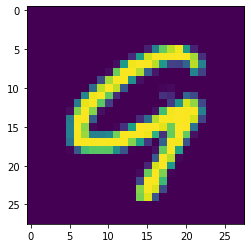

In [ ]:
import struct
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
#from torch.nn.functional import binary_cross_entropy_with_logits as bce_loss

#from hw3_utils import BASE_URL, download, GANDataset


class DNet(nn.Module):
    """This is discriminator network."""

    def __init__(self):
        super(DNet, self).__init__()

        # TODO: implement layers here
        self.conv1=nn.Conv2d(1,2,kernel_size = 3, stride = 1, padding = 1, bias=True)
        self.ReLU1= nn.ReLU()
        self.pooling1=nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2=nn.Conv2d(2,4,kernel_size = 3,stride = 1, padding = 1, bias=True)
        self.ReLU2= nn.ReLU()
        self.pooling2=nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv3=nn.Conv2d(4,8,kernel_size = 3,stride = 1, padding = 0, bias=True)
        self.ReLU3= nn.ReLU()
        self.linear1=nn.Linear(8*5*5, 1)

        pass

        self._weight_init()

    def _weight_init(self):
        # TODO: implement weight initialization here
        for i in self.children():
          if isinstance(i,nn.Conv2d):
            nn.init.kaiming_uniform_(i.weight)
            if i.bias is not None:
              nn.init.constant_(i.bias,0)
          elif isinstance(i,nn.Linear):
            nn.init.kaiming_uniform_(i.weight)
            if i.bias is not None:
              nn.init.constant_(i.bias,0)

        pass

    def forward(self, x):
        # TODO: complete forward function
        x=self.pooling1(self.ReLU1(self.conv1(x)))
        x=self.pooling2(self.ReLU2(self.conv2(x)))
        x=self.ReLU3(self.conv3(x))
        #x=x.view(x.size(0),-1)
        x=x.view(-1,8*5*5)
        x=self.linear1(x)
        return x
        pass


class GNet(nn.Module):
    """This is generator network."""

    def __init__(self, zdim):
        """
        Parameters
        ----------
            zdim: dimension for latent variable.
        """
        super(GNet, self).__init__()

        # TODO: implement layers here
        self.layer1=nn.Linear(zdim,1568,bias=True)
        self.leaky1=nn.LeakyReLU(0.2)
        self.upsample1=nn.Upsample(scale_factor=2)
        self.convolution1=nn.Conv2d(32,16,kernel_size=3,stride = 1, padding = 1, bias=True)
        self.leaky2=nn.LeakyReLU(0.2)
        self.upsample2=nn.Upsample(scale_factor=2)
        self.convolution2=nn.Conv2d(16,8,kernel_size=3,stride = 1, padding = 1, bias=True)
        self.leaky3=nn.LeakyReLU(0.2)
        self.convolution3=nn.Conv2d(8,1,kernel_size=3,stride = 1, padding = 1, bias=True)
        self.sigmoid=nn.Sigmoid()

        self._weight_init()

    def _weight_init(self):
        # TODO: implement weight initialization here
        for i in self.children():
          if isinstance(i,nn.Conv2d):
            nn.init.kaiming_uniform_(i.weight)
            if i.bias is not None:
              nn.init.constant_(i.bias,0)
          elif isinstance(i,nn.Linear):
            nn.init.kaiming_uniform_(i.weight)
            if i.bias is not None:
              nn.init.constant_(i.bias,0)
        pass

    def forward(self, z):
        """
        Parameters
        ----------
            z: latent variables used to generate images.
        """
        # TODO: complete forward function
        z1= self.layer1(z)
        z1= self.leaky1(z1)
        z1=z1.view(-1,32,7,7)
        z1= self.upsample1(z1)
        z1= self.convolution1(z1)
        z1= self.leaky2(z1)
        z1=self.upsample2(z1)
        z1=self.convolution2(z1)
        z1=self.leaky3(z1)
        z1=self.convolution3(z1)
        z1=self.sigmoid(z1)
        return z1

        pass


class GAN:
    def __init__(self, zdim=64):
        """
        Parameters
        ----------
            zdim: dimension for latent variable.
        """
        torch.manual_seed(2)
        self._dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self._zdim = zdim
        self.disc = DNet().to(self._dev)
        self.gen = GNet(self._zdim).to(self._dev)

    def _get_loss_d(self, batch_size, batch_data, z):
        """This function computes loss for discriminator.

        Parameters
        ----------
            batch_size: #data per batch.
            batch_data: data from dataset.
            z: random latent variable.
        """
        # TODO: implement discriminator's loss function
        loss = nn.BCEWithLogitsLoss()
        data_fake= self.gen(z)
        logits_real=self.disc(batch_data)
        logits_fake=self.disc(data_fake.detach())

        real_loss= loss(logits_real,torch.ones(batch_size,1))
        fake_loss= loss(logits_fake,torch.zeros(batch_size,1))
        loss_d=(real_loss+fake_loss)/2
        return loss_d

        pass

    def _get_loss_g(self, batch_size, z):
        """This function computes loss for generator.
        Compute -\sum_z\log{D(G(z))} instead of \sum_z\log{1-D(G(z))}

        Parameters
        ----------
            batch_size: #data per batch.
            z: random latent variable.
        """
        # TODO: implement generator's loss function
        loss = nn.BCEWithLogitsLoss()
        data_fake= self.gen(z)
        logits_fake=self.disc(data_fake)
        loss_g= loss(logits_fake,torch.ones(batch_size,1))
        return loss_g
        pass

    def train(self, iter_d=1, iter_g=1, n_epochs=100, batch_size=256, lr=0.0002):

        # first download
        f_name = "train-images-idx3-ubyte.gz"
        download(BASE_URL + f_name, f_name)

        print("Processing dataset ...")
        train_data = GANDataset(
            f"./data/{f_name}",
            self._dev,
            transform=transforms.Compose([transforms.Normalize((0.0,), (255.0,))]),
        )
        print(f"... done. Total {len(train_data)} data entries.")

        train_loader = DataLoader(
            train_data,
            batch_size=batch_size,
            shuffle=True,
            num_workers=0,
            drop_last=True,
        )

        dopt = optim.Adam(self.disc.parameters(), lr=lr, weight_decay=0.0)
        dopt.zero_grad()
        gopt = optim.Adam(self.gen.parameters(), lr=lr, weight_decay=0.0)
        gopt.zero_grad()

        for epoch in tqdm(range(n_epochs)):
            for batch_idx, data in tqdm(
                enumerate(train_loader), total=len(train_loader)
            ):

                z = 2 * torch.rand(data.size()[0], self._zdim, device=self._dev) - 1

                if batch_idx == 0 and epoch == 0:
                    plt.imshow(data[0, 0, :, :].detach().cpu().numpy())
                    plt.savefig("goal.pdf")

                if batch_idx == 0 and epoch % 10 == 0:
                    with torch.no_grad():
                        tmpimg = self.gen(z)[0:64, :, :, :].detach().cpu()
                    save_image(
                        tmpimg, "test_{0}.png".format(epoch), nrow=8, normalize=True
                    )

                dopt.zero_grad()
                for k in range(iter_d):
                    loss_d = self._get_loss_d(batch_size, data, z)
                    loss_d.backward()
                    dopt.step()
                    dopt.zero_grad()

                gopt.zero_grad()
                for k in range(iter_g):
                    loss_g = self._get_loss_g(batch_size, z)
                    loss_g.backward()
                    gopt.step()
                    gopt.zero_grad()

            print(f"E: {epoch}; DLoss: {loss_d.item()}; GLoss: {loss_g.item()}")


if __name__ == "__main__":
    gan = GAN()
    gan.train()